### Imports

In [1]:
import os
import sys
import random

In [2]:
import time

In [3]:
import numpy as np

In [4]:
import torch
from torch.utils.data import Dataset

In [5]:
from torch import nn

In [6]:
from torch.nn import functional

In [7]:
import torchvision
import torchvision.transforms as transforms

In [8]:
from torchvision.transforms import InterpolationMode

In [9]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [10]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.setup import LinearOpticalSetup
from svetlanna.detector import Detector, DetectorProcessorClf

In [11]:
from svetlanna.transforms import ToWavefront

In [12]:
# datasets of wavefronts
from src.wf_datasets import DatasetOfWavefronts
from src.wf_datasets import WavefrontsDatasetSimple

In [13]:
from tqdm import tqdm

In [14]:
from datetime import datetime

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Optical Neural Network

In that example notebook we will try to realize a simple architecture of an optical neural network from [an article](https://www.science.org/doi/10.1126/science.aat8084).

> In general, the phase and amplitude of eachneuron can be learnable parameters, providinga complex-valued modulation at each layer, which improves the inference performance of the diffractive network.

> ... we first trained it as a digit classifierto perform automated classification of hand-written digits, from $0$ to $9$. Forthis task, phase-only transmission masks weredesigned by training **a five-layer** $D^2 NN$ with $55,000$ images ($5000$ validation images) from the MNIST handwritten digit data-base.

>  We then used continuous-wave illumination at $0.4$ $THz$...

Some info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) (information about MNIST classification):

> Because we consider coherent illumination, the input information can be encoded in the amplitude and/or phase channels of the input plane.

> For each layer of the $D^2NN$, we set we set the neuron size to be $400$ $\mu m$...

> At the detector/output plane, we measured the intensity of the network output...

## Additional information

In another [article](https://ieeexplore.ieee.org/abstract/document/8732486) (the extended article) of the same authors sume details were clarified: 

> In our numerical simulations, we used a neuron size of approximately $0.53 \times \lambda $

>  In addition, the height and width of each diffractive layer was set to include $200 \times 200 = 40K$ neurons per layer.

# 1. Simulation parameters

In [16]:
working_frequency = 0.4 * 1e12 # [Hz]
c_const = 299_792_458  # [m / s]

In [17]:
working_wavelength = c_const / working_frequency  # [m]
print(f'lambda = {working_wavelength * 1e6:.3f} um')

lambda = 749.481 um


In [18]:
# neuron size (square)
neuron_size = 0.53 * working_wavelength  # [m]
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 397.225 um


In [19]:
DETECTOR_SIZE = (200, 200)  # from the extended article!
# an actual zone where weights will be updated during a training process

In [20]:
# number of neurons in simulation
x_layer_nodes = DETECTOR_SIZE[1] * 2
y_layer_nodes = DETECTOR_SIZE[0] * 2
# Comment: Two times larger because we will use apertures and a different propagator
#          than in the article!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 400 x 400 = 160000


In [21]:
# physical size of each layer (from the article) - (8 x 8) [cm]
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in cm): {x_layer_size_m * 1e2} x {y_layer_size_m * 1e2}')

Layer size (in cm): 15.889000274 x 15.889000274


In [22]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation (Data Engineer)

## 2.1. [Fashion-MNIST Dataset](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

In [23]:
# initialize a directory for a dataset
DATA_FOLDER = './data'  # folder to store data

### 2.1.1. Load Train and Test datasets of images

In [24]:
# TRAIN (images)
fashion_mnist_train_ds = torchvision.datasets.FashionMNIST(
    root=DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

In [25]:
# TEST (images)
fashion_mnist_test_ds = torchvision.datasets.FashionMNIST(
    root=DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

In [26]:
print(f'Train data: {len(fashion_mnist_train_ds)}')
print(f'Test data : {len(fashion_mnist_test_ds)}')

Train data: 60000
Test data : 10000


In [27]:
LABEL_TO_NAME = {
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot',
}

### 2.1.2. Create Train and Test datasets of wavefronts

From [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486):

> Input objects were encoded in amplitude channel (MNIST) of the input plane and were illuminated with a uniform plane wave at a wavelength of $\lambda$ to match the conditions introduced in [[1]](https://www.science.org/doi/10.1126/science.aat8084) for all-optical classification.

In [28]:
# select modulation type
MODULATION_TYPE = 'phase'  # using ONLY phase to encode each picture in a Wavefront! amplitude is constant!

In [29]:
resize_y = int(DETECTOR_SIZE[0] / 2)
resize_x = int(DETECTOR_SIZE[1] / 2)  # shape for transforms.Resize
# Comment: Looks like in the extended article MNIST pictures were resized to 100 x 100 neurons!

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [30]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          # interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

In [31]:
# TRAIN dataset of WAVEFRONTS
fashion_mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=fashion_mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [32]:
# TEST dataset of WAVEFRONTS
fashion_mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=fashion_mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [33]:
print(f'Train data: {len(fashion_mnist_train_ds)}')
print(f'Test data : {len(fashion_mnist_test_ds)}')

Train data: 60000
Test data : 10000


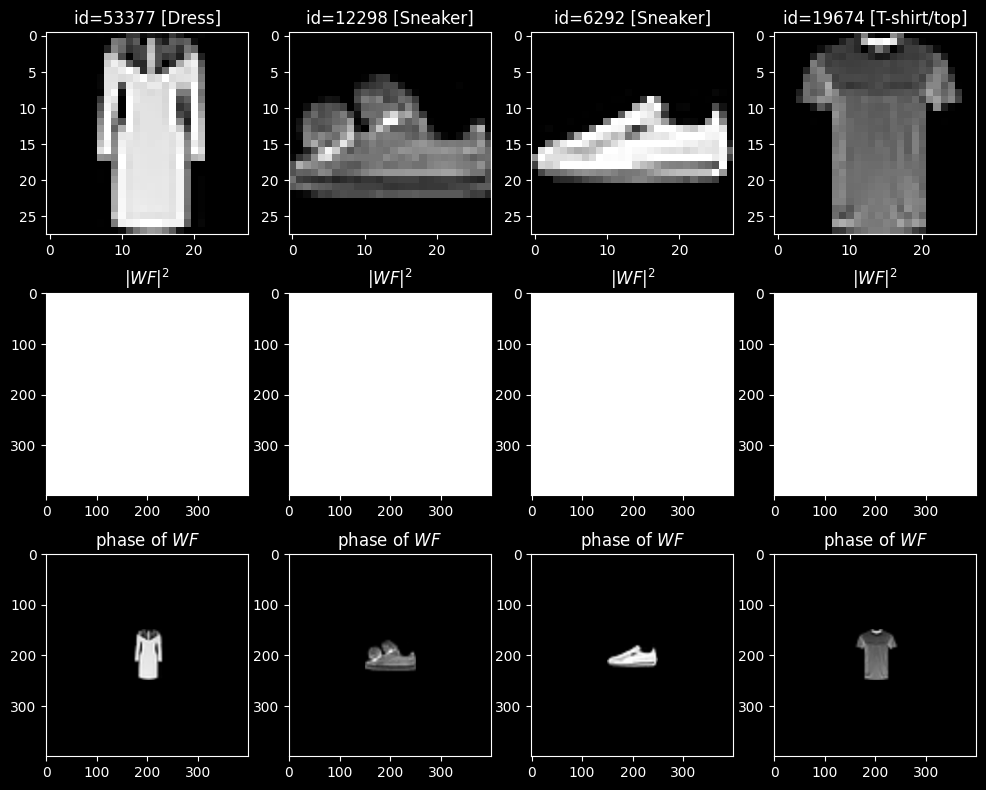

In [34]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(78)
train_examples_ids = random.sample(range(len(fashion_mnist_train_ds)), n_examples)

all_examples_wavefronts = []

n_lines = 3
fig, axs = plt.subplots(n_lines, n_examples, figsize=(n_examples * 3, n_lines * 3.2))
for ind_ex, ind_train in enumerate(train_examples_ids):
    image, label = fashion_mnist_train_ds[ind_train]
    
    axs[0][ind_ex].set_title(f'id={ind_train} [{LABEL_TO_NAME[label]}]')
    axs[0][ind_ex].imshow(image, cmap='gray')

    wavefront, wf_label = fashion_mnist_wf_train_ds[ind_train]
    assert isinstance(wavefront, Wavefront)

    all_examples_wavefronts.append(wavefront)

    axs[1][ind_ex].set_title(f'$|WF|^2$')
    # here we can plot intensity for a wavefront
    axs[1][ind_ex].imshow(
        wavefront.intensity, cmap='gray',
        vmin=0, vmax=1
    )
    
    axs[2][ind_ex].set_title(f'phase of $WF$')
    axs[2][ind_ex].imshow(
        wavefront.phase, cmap='gray',
        vmin=-torch.pi, vmax=torch.pi
    )

plt.show()

# 3. Optical network

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> Following the corresponding $D^2NN$ design, the axial distance between two successive 3D-printed layers was set to be $3.0$ $cm$...

> The distance between detector/output plane and the last layer of the optical neural network was adjusted as $3$ $cm$...

From [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486):

> ... the axial distance between the successive diffractive layers is set to be $\sim 40 \times \lambda$ as in [[1]](https://www.science.org/doi/10.1126/science.aat8084) ...

In [35]:
NUM_OF_DIFF_LAYERS = 5  # number of diffractive layers
FREE_SPACE_DISTANCE = 40 * working_wavelength  # [m] - distance between difractive layers

In [36]:
print(f'Distance between layers is {FREE_SPACE_DISTANCE * 1e2:.3f} cm')

Distance between layers is 2.998 cm


## 3.1. Architecture
See Figure 2A from [the article](https://www.science.org/doi/10.1126/science.aat8084).

See Figure 1(a) from [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486).

### 3.1.1. List of Elements

> a diffractive layer ... neurons ... were initialized with $\pi$ for phase values and $1$ for amplitude values ...

> a $5$-layer, phase-only (complex-valued) diffractive optical network ...

In [37]:
MAX_PHASE = 2 * np.pi
MAX_TRANSMISSION = 1

In [38]:
PHASE_ONLY = True
# if True - we don't add extra learnable layers of Aperture (amplitude modulation)!

In [39]:
FREESPACE_METHOD = 'AS'  # we use another method in contrast to the extended article!!!

In [40]:
INIT_PHASES = torch.ones(NUM_OF_DIFF_LAYERS) * np.pi
INIT_TRANSMISSION = torch.ones(NUM_OF_DIFF_LAYERS) * 0.9  
# TODO: Now we cant initialize transmission coefficients as ones if 1 is a maximal value!

In [41]:
# functions that return single elements for further architecture

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_transmission_layer(
    sim_params: SimulationParameters,
    value,  # must be from range [0, 1]
    max_transmission=1
):
    """
    Returns Aperture with a constant transmission coefficient mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.Aperture(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_transmission
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!

Function to construct a list of elements to reproduce an architecture from [the extended article](https://ieeexplore.ieee.org/abstract/document/8732486):

In [42]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_method,
    transmission_values,
    phase_values,
    apertures=False,
    aperture_size=(100, 100)
):
    """
    Composes a list of elements for the setup.
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_method : str
        Propagation method for free spaces in a setup.
    transmission_values : torch.Tensor()
        Torch tensor of transmission coefficients to generate constant masks for apertures.
    phase_values : torch.Tensor()
        Torch tensor of phase values to generate constant masks for diffractive layers.
        
    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        A size of apertures.
        
    Returns
    -------
    elements_list : list(Element)
        List of Elements for an optical setup.
    """
    elements_list = []  # list of elements
    
    if apertures:  # equal masks for all apertures (select a part in the middle)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
        
        # padding transform to match aperture size with simulation parameters     
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # first FreeSpace layer before first DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            FREE_SPACE_DISTANCE,  # in [m]
            freespace_method=freespace_method,
        )
    )

    # compose the architecture
    for ind_layer in range(num_layers):

        # add strickt square Aperture
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=aperture_mask
                )
            )
            
        # -----------------------------------------------------------------------
        if not PHASE_ONLY:  # add learnable Aperture (learnable transmission mask)
            elements_list.append(
                get_const_transmission_layer(
                    simulation_parameters,  # simulation parameters for the notebook
                    value=transmission_values[ind_layer].item(),
                    max_transmission=MAX_TRANSMISSION
                )
            )
        
        # add DiffractiveLayer (learnable phase mask)
        elements_list.append(
            get_const_phase_layer(
                simulation_parameters,  # simulation parameters for the notebook
                value=phase_values[ind_layer].item(),
                max_phase=MAX_PHASE
            )
        )
        # -----------------------------------------------------------------------
        
        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                FREE_SPACE_DISTANCE,  # in [m]
                freespace_method=freespace_method,
            )
        )

    # ---------------------------------------------------------------------------
    # add add strickt square Aperture before Detector
    if apertures:
        elements_list.append(
            elements.Aperture(
                simulation_parameters=simulation_parameters,
                mask=aperture_mask
            )
        )
    
    # add Detector in the end of the system!
    elements_list.append(
        Detector(
            simulation_parameters=simulation_parameters,
            func='intensity'  # detector that returns intensity
        )
    )

    return elements_list

In [43]:
architecture_elements_list = get_elements_list(
    num_layers=NUM_OF_DIFF_LAYERS,
    simulation_parameters=SIM_PARAMS,
    freespace_method=FREESPACE_METHOD,
    transmission_values=INIT_TRANSMISSION,
    phase_values=INIT_PHASES,
    apertures=True,
    aperture_size=DETECTOR_SIZE
)

print(f'Number of elements in the system (including Detector): {len(architecture_elements_list)}')

Number of elements in the system (including Detector): 18


### 3.1.2. Compose `LinearOpticalSetup`

In [44]:
def get_setup(simulation_parameters):
    """
    Returns an optical setup. Recreates all elements.
    """
    elements_list = get_elements_list(
        num_layers=NUM_OF_DIFF_LAYERS,
        simulation_parameters=SIM_PARAMS,
        freespace_method=FREESPACE_METHOD,
        transmission_values=INIT_TRANSMISSION,
        phase_values=INIT_PHASES,
        apertures=True,
        aperture_size=DETECTOR_SIZE
    )  # recreate a list of elements

    return LinearOpticalSetup(elements=elements_list)

In [45]:
# creaye an optical setup
optical_setup = get_setup(SIM_PARAMS)

In [46]:
optical_setup.net

Sequential(
  (0): FreeSpace()
  (1): Aperture()
  (2): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (3): FreeSpace()
  (4): Aperture()
  (5): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (6): FreeSpace()
  (7): Aperture()
  (8): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (9): FreeSpace()
  (10): Aperture()
  (11): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (12): FreeSpace()
  (13): Aperture()
  (14): DiffractiveLayer(
    (mask_svtlnn_inner_parameter): InnerParameterStorageModule()
  )
  (15): FreeSpace()
  (16): Aperture()
  (17): Detector()
)

#### Example of a wavefrnt propagation

In [47]:
example_wf = fashion_mnist_wf_train_ds[128][0]

In [48]:
LABEL_TO_NAME[fashion_mnist_wf_train_ds[128][1]]

'Coat'

In [49]:
setup_scheme, wavefronts = optical_setup.stepwise_forward(example_wf)

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Aperture] -(17)-> [18. Detector] -(18)->


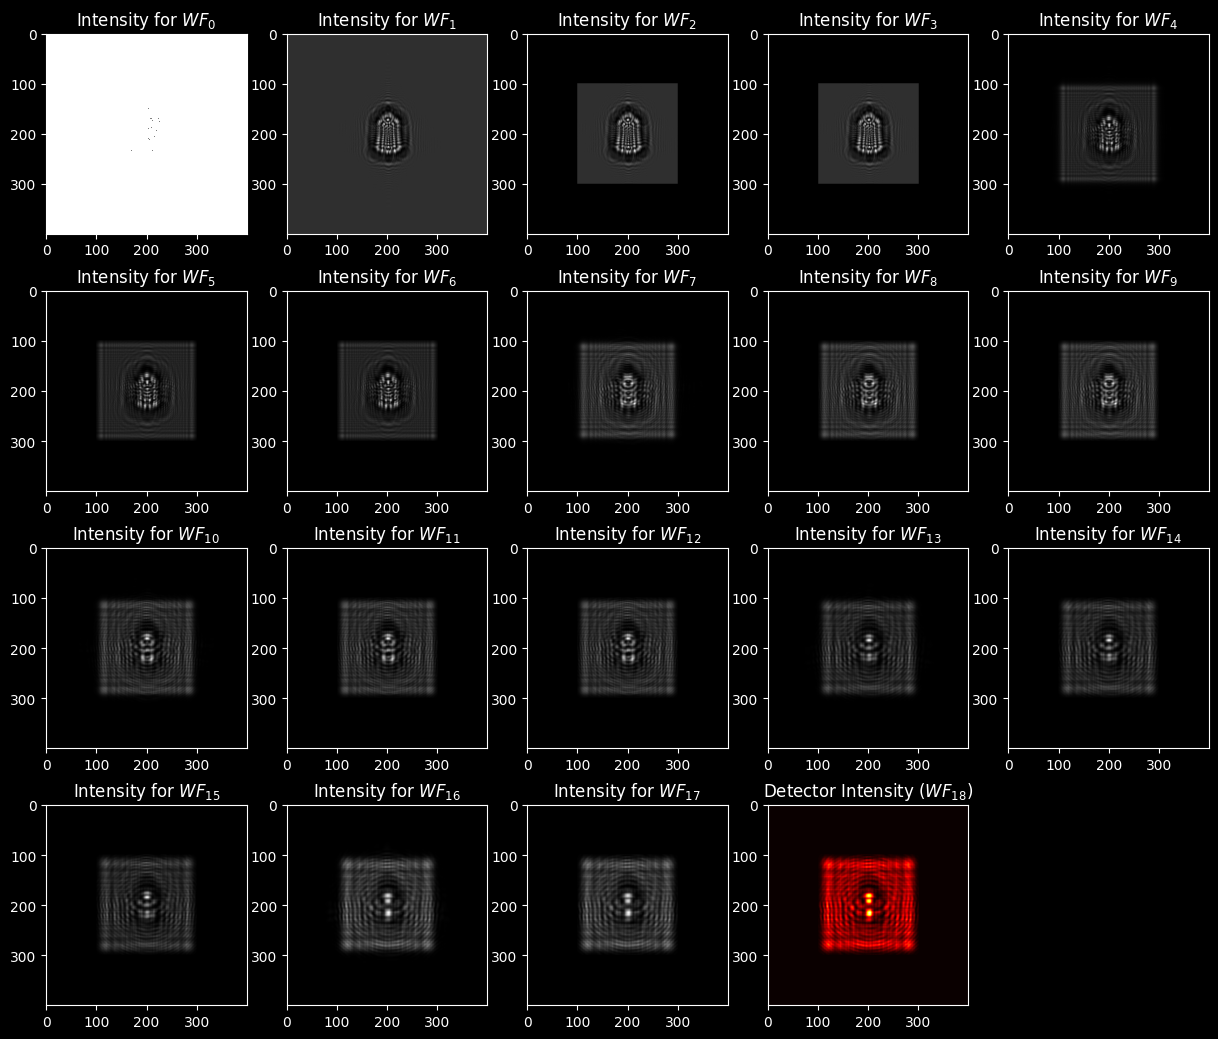

In [52]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(optical_setup.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=-torch.pi, vmax=torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!

plt.show()

### 3.1.3 Detector processor

> ... size of these detectors $(6.4 \lambda \times 6.4 \lambda)$ ...

In [53]:
import src.detector_segmentation as detector_segmentation

In [54]:
number_of_classes = 10

#### Detector mask

In [55]:
detector_segment_size = 6.4 * working_wavelength

In [56]:
# size of each segment in neurons
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [57]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

#### Detector mask

In [58]:
detector_squares_mask = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)

#### Detector processor
> ... the measured intensities by D detectors at the output plane are normalized such that they lie in the interval $(0,10)$ for each sample. With $I_l$ denoting the total optical signal impinging onto the $l^\text{th}$ detector at the output plane, the normalized intensities, $I_l^\prime$, can be found by,
$$ I_l^\prime = \frac{I_l}{\max \left\{ I_l \right\} } \times 10.$$


In [59]:
class DetectorProcessorOzcanClf(DetectorProcessorClf):
    """
    Redefine forward in DetectorProcessorCls to match a training process.
    """
    
    def batch_forward(self, batch_detector_data: torch.Tensor) -> torch.Tensor:
        """
        Calculates probabilities of belonging to classes for a batch of detector images.
        ...

        Parameters
        ----------
        batch_detector_data : torch.Tensor
            A batch of images from a detector.
            shape=(batch_size, ... 'H', 'W').

        Returns
        -------
        torch.Tensor
            A tensor of probabilities of element belonging to classes for further calculation of loss.
            shape=(batch_size, self.num_classes)
        """
        batch_size = batch_detector_data.size()[0]  # batch size is a 0'th dimension!

        integrals_by_classes = torch.zeros(size=(batch_size, self.num_classes)).to(self._DetectorProcessorClf__device)
        for ind_class in range(self.num_classes):
            integrals_by_classes[:, ind_class] = (
                    self.batch_zone_integral(batch_detector_data, ind_class)
            )

        return integrals_by_classes / torch.unsqueeze(torch.max(integrals_by_classes, dim=1)[0], 1) * 10

In [60]:
detector_processor = DetectorProcessorOzcanClf(
    simulation_parameters=SIM_PARAMS,
    num_classes=number_of_classes,
    segmented_detector=detector_squares_mask,
)

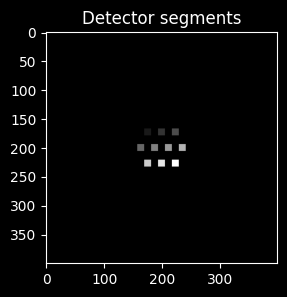

In [61]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(detector_processor.segmented_detector, cmap='grey')

plt.show()

#### Zones visualization. To draw zones on a detector...

In [62]:
ZONES_HIGHLIGHT_COLOR = 'w'
ZONES_LW = 0.5
selected_detector_mask = detector_processor.segmented_detector.clone().detach()

In [63]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 0.5
    
    for ind_class in range(number_of_classes):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

# 4. Training of the network

Variables at the moment
- `lin_optical_setup` : `LinearOpticalSetup` – a linear optical network composed of Elements
- `detector_processor` : `DetectorProcessorClf` – this layer process an image from the detector and calculates probabilities of belonging to classes.

In [64]:
DEVICE = 'cpu'  # 'mps' is not support a CrossEntropyLoss

# 'cuda' will be tested in another example

In [65]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> The training batch size was set to be $8$...

In [66]:
train_bs = 8  # a batch size for training set
val_bs = 20

> Forthis task, phase-only transmission masks weredesigned by training a five-layer $D^2 NN$ with $55000$ images ($5000$ validation images) from theMNIST (Modified National Institute of Stan-dards and Technology) handwritten digit data-base.

In [67]:
# mnist_wf_train_ds
train_wf_ds, val_wf_ds = torch.utils.data.random_split(
    dataset=fashion_mnist_wf_train_ds,
    lengths=[55000, 5000],  # sizes from the article
    generator=torch.Generator().manual_seed(178)  # for reproducibility
)

In [68]:
train_wf_loader = torch.utils.data.DataLoader(
    train_wf_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

val_wf_loader = torch.utils.data.DataLoader(
    val_wf_ds,
    batch_size=val_bs,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Info from [a supplementary material](https://www.science.org/doi/suppl/10.1126/science.aat8084/suppl_file/aat8084-lin-sm-rev-3.pdf) for MNIST classification:

> We used the stochastic gradient descent algorithm, Adam, to back-propagate the errors and update the
layers of the network to minimize the loss function.

Info from the extended article:
> a back-propagation method by applying the adaptive moment estimation optimizer (Adam) with a learning rate of $10^{−3}$

In [69]:
LR = 1e-3

In [70]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

In [71]:
loss_func_clf = nn.CrossEntropyLoss()
loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [72]:
from src.clf_loops import onn_train_clf, onn_validate_clf

## 4.2. Training of the optical network

### 4.2.1. Before training

Diffractive layers masks are constants!

#### Metrics for Test datasets

In [73]:
test_wf_loader = torch.utils.data.DataLoader(
    fashion_mnist_wf_test_ds,
    batch_size=10,
    shuffle=False,
    # num_workers=2,
    drop_last=False,
)  # data loader for a test MNIST data

In [74]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)
# SIM_PARAMS = SIM_PARAMS.to(DEVICE)

In [75]:
test_losses_0, _, test_accuracy_0 = onn_validate_clf(
    optical_setup.net,  # optical network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.97it/s]

Results before training on TEST set:
	CE loss : 5.723277
	Accuracy : 10.9 %


### 4.2.2. Training

In [76]:
n_epochs = 20
print_each = 2  # print each n'th epoch info

In [77]:
scheduler = None  # sheduler for a lr tuning during training 

In [78]:
# Recreate a system to restart training!
ozcan_optical_setup = get_setup(SIM_PARAMS)

# Linc optimizer to a recreated net!
optimizer_clf = get_adam_optimizer(ozcan_optical_setup.net)

In [79]:
# lin_optical_setup.net = lin_optical_setup.net.to(DEVICE)

In [80]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = onn_train_clf(
        ozcan_optical_setup.net,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = onn_validate_clf(
        ozcan_optical_setup.net,  # optical network composed in 3.
        val_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve accuracies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [37:26<00:00,  3.06it/s]


Training results
	CE loss : 0.828704
	Accuracy : 73.3 %
	------------   2246.80 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:56<00:00,  2.14it/s]


Validation results
	CE loss : 0.515817
	Accuracy : 82.8 %
	------------   116.81 s
Epoch #2: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [37:57<00:00,  3.02it/s]


Training results
	CE loss : 0.464643
	Accuracy : 84.0 %
	------------   2277.29 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:41<00:00,  2.45it/s]


Validation results
	CE loss : 0.450931
	Accuracy : 84.7 %
	------------   101.90 s
Epoch #4: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [25:16<00:00,  4.53it/s]


Training results
	CE loss : 0.382183
	Accuracy : 86.7 %
	------------   1516.73 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.41it/s]


Validation results
	CE loss : 0.384858
	Accuracy : 86.7 %
	------------   73.33 s
Epoch #6: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [25:10<00:00,  4.55it/s]


Training results
	CE loss : 0.345457
	Accuracy : 88.0 %
	------------   1510.72 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.46it/s]


Validation results
	CE loss : 0.419379
	Accuracy : 85.0 %
	------------   72.23 s
Epoch #8: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [25:02<00:00,  4.57it/s]


Training results
	CE loss : 0.321980
	Accuracy : 88.7 %
	------------   1502.95 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.46it/s]


Validation results
	CE loss : 0.359935
	Accuracy : 87.8 %
	------------   72.21 s
Epoch #10: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:51<00:00,  4.61it/s]


Training results
	CE loss : 0.303036
	Accuracy : 89.5 %
	------------   1491.95 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s]


Validation results
	CE loss : 0.348704
	Accuracy : 87.9 %
	------------   71.94 s
Epoch #12: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:43<00:00,  4.63it/s]


Training results
	CE loss : 0.286850
	Accuracy : 90.0 %
	------------   1483.74 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s]


Validation results
	CE loss : 0.348885
	Accuracy : 88.1 %
	------------   71.89 s
Epoch #14: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:47<00:00,  4.62it/s]


Training results
	CE loss : 0.274784
	Accuracy : 90.4 %
	------------   1487.61 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s]


Validation results
	CE loss : 0.328381
	Accuracy : 88.9 %
	------------   71.93 s
Epoch #16: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:46<00:00,  4.62it/s]


Training results
	CE loss : 0.263567
	Accuracy : 90.8 %
	------------   1486.76 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:11<00:00,  3.48it/s]


Validation results
	CE loss : 0.348836
	Accuracy : 87.8 %
	------------   71.79 s
Epoch #18: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [24:58<00:00,  4.59it/s]


Training results
	CE loss : 0.254486
	Accuracy : 91.2 %
	------------   1498.64 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:12<00:00,  3.46it/s]


Validation results
	CE loss : 0.335227
	Accuracy : 88.6 %
	------------   72.33 s
Epoch #20: 

train: 100%|█████████████████████████████████████████████████████████████████████████████| 6875/6875 [25:08<00:00,  4.56it/s]


Training results
	CE loss : 0.245255
	Accuracy : 91.5 %
	------------   1508.42 s


validation: 100%|██████████████████████████████████████████████████████████████████████████| 250/250 [01:13<00:00,  3.42it/s]

Validation results
	CE loss : 0.326649
	Accuracy : 88.8 %
	------------   73.14 s


#### Learning curves (CrossEntropyLoss and Accuracy)

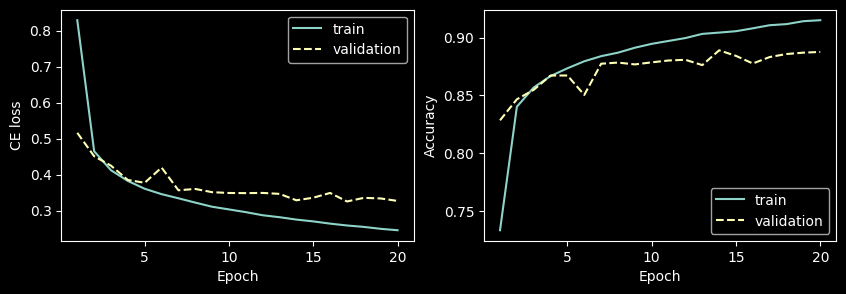

In [81]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), train_epochs_losses, label='train')
axs[0].plot(range(1, n_epochs + 1), val_epochs_losses, linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

In [82]:
# array with all losses
# TODO: make with PANDAS?
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

#### Trained phase masks

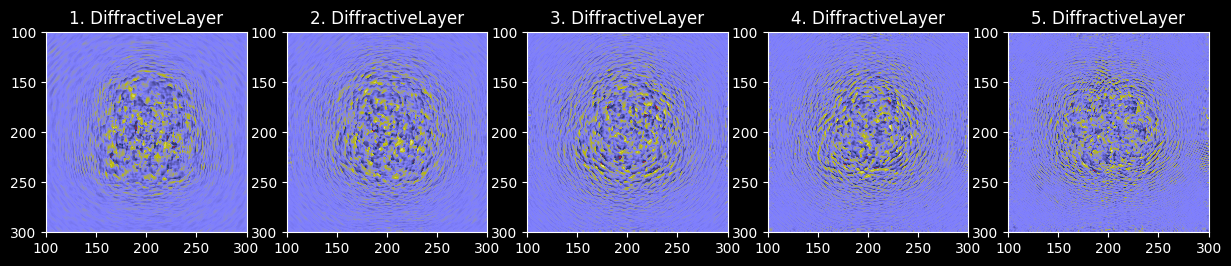

In [84]:
n_cols = NUM_OF_DIFF_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'
within_aperture = True

for ind_layer, layer in enumerate(ozcan_optical_setup.net):
    if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        ax_this.set_title(f'{ind_diff_layer + 1}. DiffractiveLayer')

        trained_mask = layer.mask.detach()
        
        ax_this.imshow(         
            trained_mask, cmap=cmap,
            vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

    # select only a part within apertures!
    if within_aperture:
        # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

### 4.2.3. Saving the results

#### Pathes

In [85]:
RESULTS_FOLDER = 'models/reproduced_results/Fashion-MNIST_Ozcan_2018-2020'

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [86]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Saving model weights and learning curves

In [87]:
# saving model
torch.save(ozcan_optical_setup.net.state_dict(), model_filepath)

In [88]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

# 5. Load saved weights for the model

In [89]:
RESULTS_FOLDER = 'models/reproduced_results/Fashion-MNIST_Ozcan_2018-2020'

load_model_filepath = f'{RESULTS_FOLDER}/optical_setup_net.pth'

In [90]:
# setup to load weights
ozcan_optical_setup_loaded = get_setup(SIM_PARAMS)

# LOAD WEIGHTS
ozcan_optical_setup_loaded.net.load_state_dict(torch.load(load_model_filepath))

/var/folders/mt/0w6nmsr119bb2g4h4xrv9p6m0000gn/T/ipykernel_15938/484346891.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ozcan_optical_setup_loaded.net.load_state_dict

<All keys matched successfully>

## 5.1. Calculate metrics on test set for the loaded model

Checking if the loaded model works correctly!

In [91]:
test_losses_1, _, test_accuracy_1 = onn_validate_clf(
    ozcan_optical_setup_loaded.net,  # optical network with loaded weights
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results after training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_1):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_1 * 100):>0.1f} %'
)

validation: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.16it/s]

Results after training on TEST set:
	CE loss : 0.338999
	Accuracy : 88.2 %


## 5.2. Example of classification (propagation through the setup)

### 5.2.1. Select a sample to propagate

test[123] = 9 = Ankle boot


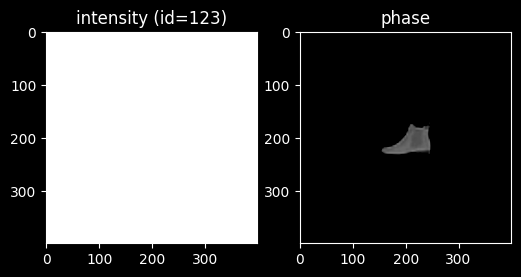

In [93]:
# plot an image
ind_test = 123
cmap = 'grey'

fig, axs = plt.subplots(1, 2, figsize=(2 * 3, 3))

test_wavefront, test_target = fashion_mnist_wf_test_ds[ind_test]
print(f'test[{ind_test}] = {test_target} = {LABEL_TO_NAME[test_target]}')

axs[0].set_title(f'intensity (id={ind_test})')
axs[0].imshow(
    test_wavefront.intensity, cmap=cmap,
    vmin=0, vmax=1
)

axs[1].set_title(f'phase')
axs[1].imshow(
    test_wavefront.phase, cmap=cmap,
    vmin=0, vmax=2 * torch.pi
)

plt.show()

In [94]:
# propagation of the example through the trained network
setup_scheme, test_wavefronts = ozcan_optical_setup_loaded.stepwise_forward(test_wavefront)

### 5.2.2. Amplitude profiles

-(0)-> [1. FreeSpace] -(1)-> [2. Aperture] -(2)-> [3. DiffractiveLayer] -(3)-> [4. FreeSpace] -(4)-> [5. Aperture] -(5)-> [6. DiffractiveLayer] -(6)-> [7. FreeSpace] -(7)-> [8. Aperture] -(8)-> [9. DiffractiveLayer] -(9)-> [10. FreeSpace] -(10)-> [11. Aperture] -(11)-> [12. DiffractiveLayer] -(12)-> [13. FreeSpace] -(13)-> [14. Aperture] -(14)-> [15. DiffractiveLayer] -(15)-> [16. FreeSpace] -(16)-> [17. Aperture] -(17)-> [18. Detector] -(18)->


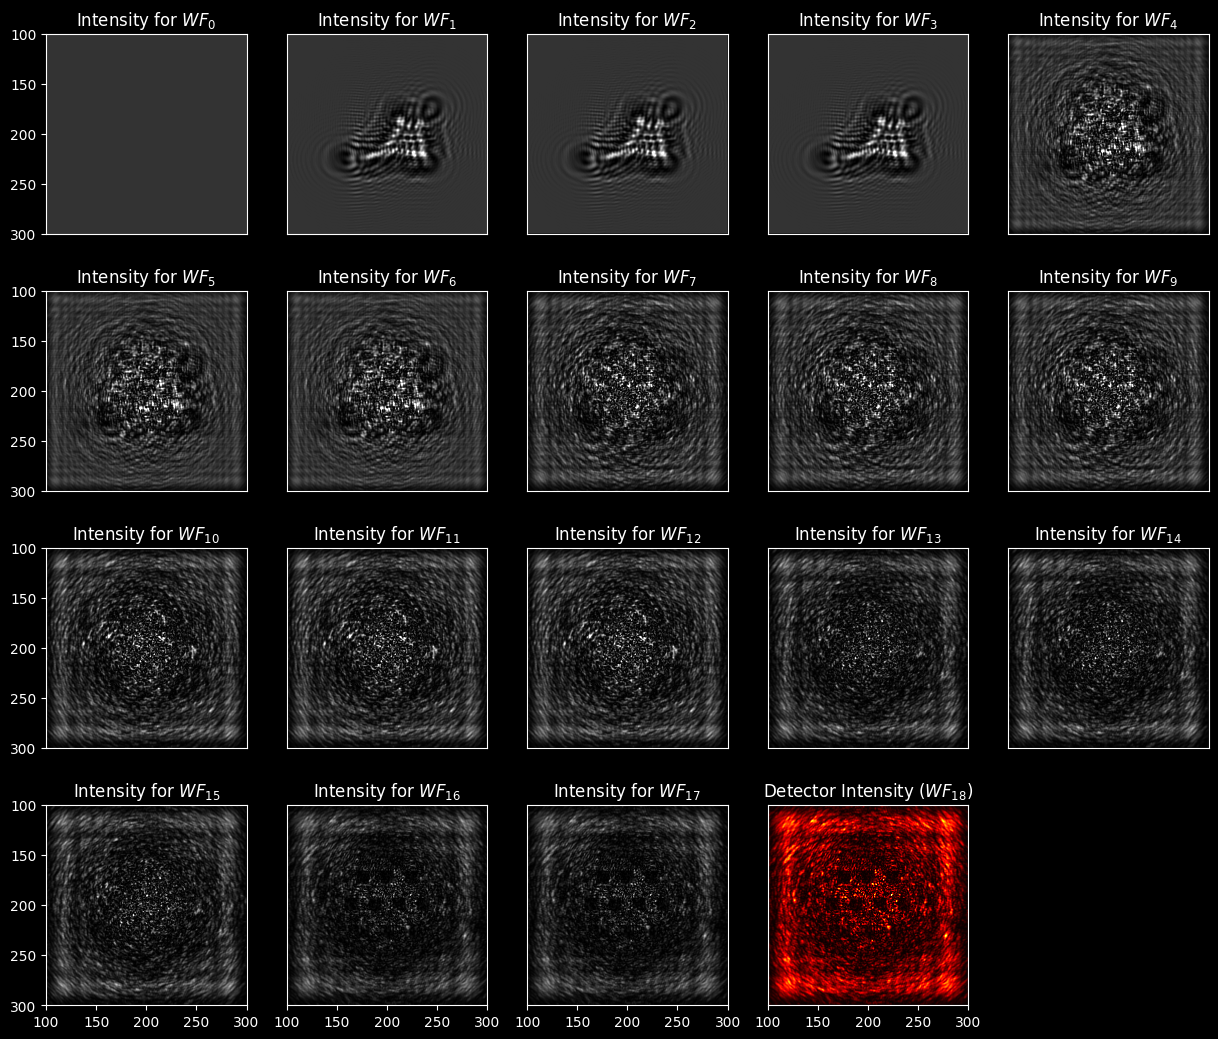

In [95]:
print(setup_scheme)  # prints propagation scheme

n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (len(ozcan_optical_setup_loaded.net) // n_cols) + 1

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
detector_cmap = 'hot'

within_aperture = True  # if true plots only the field which is within apertures!

max_intensity = 5

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3.2))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= len(test_wavefronts):
            ax_this.axis('off')

# plot wavefronts
for ind_wf, wavefront in enumerate(test_wavefronts):
    ax_this = axs[ind_wf // n_cols][ind_wf % n_cols]

    # delete unnecessary ticks
    if not (ind_wf // n_cols) == n_rows - 1:
        ax_this.set_xticks([])
    if not (ind_wf % n_cols) == 0:
        ax_this.set_yticks([])
    
    if to_plot == 'phase':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(wavefronts) - 1:
            ax_this.set_title('Phase for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.phase.detach().numpy(), cmap=cmap,
                vmin=0, vmax=2 * torch.pi
            )
        else:  # (not a wavefront!)
            ax_this.set_title('Detector phase ($WF_{' + f'{ind_wf}' + '})$')
            # Detector has no phase!

    if to_plot == 'amp':
        # plot angle for each wavefront, because intensities pictures are indistinguishable from each other
        if ind_wf < len(test_wavefronts) - 1:
            ax_this.set_title('Intensity for $WF_{' + f'{ind_wf}' + '}$')
            ax_this.imshow(
                wavefront.intensity.detach().numpy(), cmap=cmap,
                vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
        else:  # Detector output (not a wavefront!)
            ax_this.set_title('Detector Intensity ($WF_{' + f'{ind_wf}' + '})$')
            ax_this.imshow(
                wavefront.detach().numpy(), cmap=detector_cmap,
                # vmin=0, vmax=max_intensity  # uncomment to make the same limits
            )
            
    # Comment: Detector output is Tensor! It has no methods of Wavefront (like .phase or .intensity)!
    if within_aperture:
        # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

### 5.2.3. Detector picture

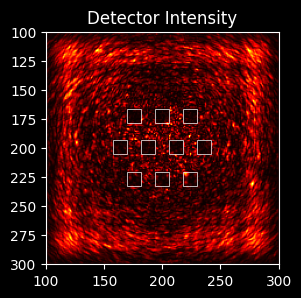

In [96]:
# create a figure with subplots
fig, ax_this = plt.subplots(1, 1, figsize=(3, 3.2))

# Detector output (not a wavefront!)
ax_this.set_title('Detector Intensity')
ax_this.imshow(
    test_wavefronts[-1].detach().numpy(), cmap='hot',
    # vmin=0, vmax=1  # uncomment to make the same limits
)

for zone in get_zones_patches(detector_squares_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax_this.add_patch(zone)

# select only a part within apertures!
x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
plt.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

In [97]:
# get probabilities of an example classification
test_probas = detector_processor.forward(test_wavefronts[-1])
# Comment: forward() method is from DetectorProcessorClf
#          p_i = I(detector_i) / sum_j(I(detector_j))
# Comment: It's another output than for batch_forward, that was used during training!

assert np.isclose(test_probas.sum().item(), 1)

for label, prob in enumerate(test_probas[0]):
    print(f'{label} : {prob * 100:.2f}%')

0 : 5.29%
1 : 6.59%
2 : 6.54%
3 : 7.01%
4 : 7.37%
5 : 8.42%
6 : 8.58%
7 : 11.78%
8 : 11.60%
9 : 26.82%


## 5.3. Energy _efficiency_

### 5.3.1. Predict all Test dataset and save all results

In [98]:
targets_test_lst = []
preds_test_lst = []

detector_sums_by_classes = [
    torch.zeros(size=SIM_PARAMS.axes_size(axs=('H', 'W'))) for _ in range(number_of_classes)
]
samples_by_classes = [0 for _ in range(number_of_classes)]
probas_sums_by_classes = [
    torch.zeros(number_of_classes) for _ in range(number_of_classes)
]

# loop over the test dataset
for ind, (wavefront_this, target_this) in enumerate(tqdm(fashion_mnist_wf_test_ds)):
    ozcan_optical_setup_loaded.net.eval()
    
    batch_wavefronts = torch.unsqueeze(wavefront_this, 0)
    batch_labels = torch.unsqueeze(torch.tensor(target_this), 0)  # to use forwards for batches
    
    with torch.no_grad():
        detector_output = ozcan_optical_setup_loaded.net(batch_wavefronts)
        # process a detector image
        batch_probas = detector_processor.batch_forward(detector_output)

        for ind_in_batch in range(batch_labels.size()[0]):
            label_this = batch_labels[ind_in_batch].item()  # true label
            targets_test_lst.append(label_this)
            
            detector_sums_by_classes[label_this] += detector_output[ind_in_batch]
            probas_sums_by_classes[label_this] += batch_probas[ind_in_batch]
            samples_by_classes[label_this] += 1

            preds_test_lst.append(batch_probas[ind_in_batch].argmax().item())

100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [02:23<00:00, 69.78it/s]


### 5.3.2. Confusion matrix

In [99]:
for class_ind in range(number_of_classes):
    probas_sums_by_classes[class_ind] /= samples_by_classes[class_ind]

In [100]:
avg_probas_mat = torch.zeros(size=(number_of_classes, number_of_classes))

for ind_class in range(number_of_classes):
    avg_probas_mat[ind_class, :] = probas_sums_by_classes[ind_class]

In [101]:
# ordinary confusion matrix
confusion_matrix = torch.zeros(size=(number_of_classes, number_of_classes), dtype=torch.int32)

for ind in range(len(fashion_mnist_wf_test_ds)):
    confusion_matrix[targets_test_lst[ind], preds_test_lst[ind]] += 1

#### Plot confusion matrices

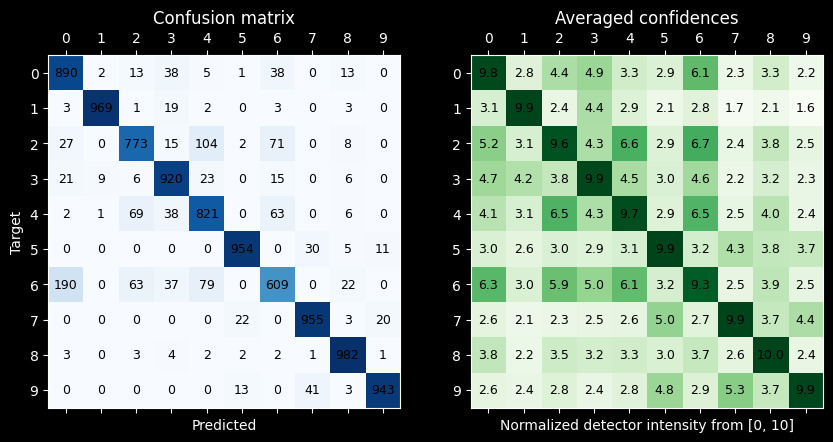

In [103]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix, cmap='Blues')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = confusion_matrix[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center', 
            c='k', fontsize=9
        )

ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(number_of_classes))
ax0.set_yticks(range(number_of_classes))

# AVERAGED PREDICTED PROBAS
ax1.set_title('Averaged confidences')
ax1.matshow(avg_probas_mat, cmap='Greens')

for i in range(number_of_classes):
    for j in range(number_of_classes):
        val = avg_probas_mat[j, i].item()
        ax1.text(
            i, j, f'{val:.1f}',
            va='center', ha='center', 
            c='k', fontsize=9
        )

ax1.set_xlabel('Normalized detector intensity from [0, 10]')

ax1.set_xticks(range(number_of_classes))
ax1.set_yticks(range(number_of_classes))
# ax1.set_yticks(range(number_of_classes), labels=['' for _ in range(number_of_classes)])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/confusion_matrix.png', bbox_inches='tight')

### 5.3.3. Averaged detector for a selected class

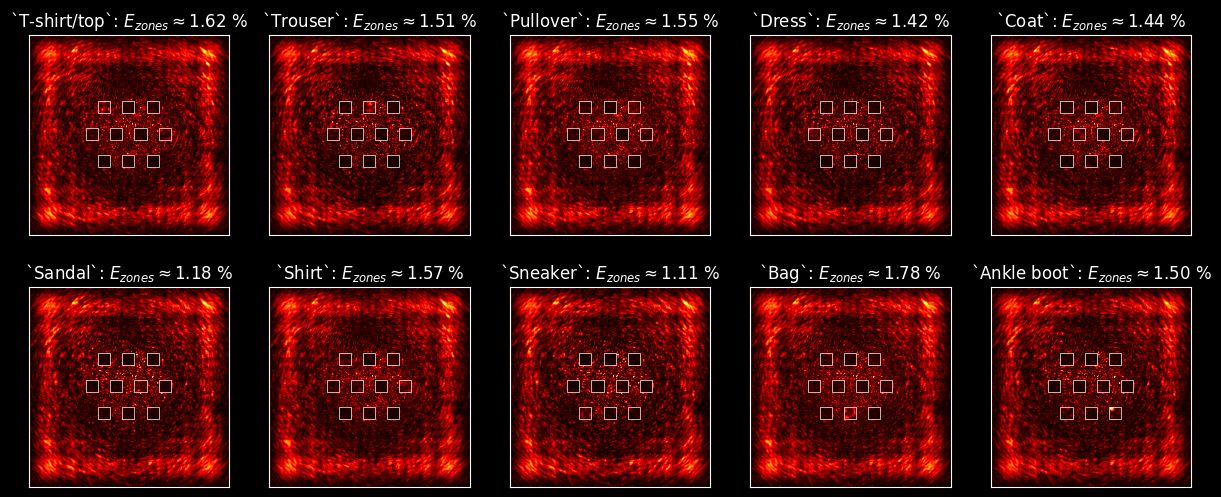

In [106]:
n_cols = 5  # number of columns to plot all wavefronts during propagation
n_rows = (number_of_classes // n_cols)

detector_cmap = 'hot'

# create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# turn off unecessary axes
for ind_row in range(n_rows):
    for ind_col in range(n_cols):
        ax_this = axs[ind_row][ind_col]
        if ind_row * n_cols + ind_col >= number_of_classes:
            ax_this.axis('off')

# plot wavefronts
for selected_class in range(number_of_classes):
    ax_this = axs[selected_class // n_cols][selected_class % n_cols]

    # focus "efficiency"
    int_over_detector_zones = 0
    
    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency = int_over_detector_zones / detector_int
    
    # Detector output (not a wavefront!)
    ax_this.set_title(
        f'`{LABEL_TO_NAME[selected_class]}`: ' + r'$E_{zones}\approx$' + 
        f'{detector_efficiency * 100:.2f} %'
    )
    ax_this.imshow(
        detector_sums_by_classes[selected_class] / samples_by_classes[selected_class],
        cmap=detector_cmap,
        # vmin=0, vmax=0.02  # uncomment to make the same limits
    )
    
    for zone in get_zones_patches(selected_detector_mask):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    ax_this.set_xticks([])
    ax_this.set_yticks([])

    # select only a part within apertures!
    x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
    y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
    ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

plt.show()

# save figure
# fig.savefig(f'{RESULTS_FOLDER}/averaged_detector_for_classes.png', bbox_inches='tight')

### 5.6.3. Detector _efficiency_

$$
\frac{\sum\limits_{\text{class}=0}^9 \left( \iint\limits_{S_\text{class}} I(x,y) \right)}{\iint\limits_{S_\text{detector}} I(x,y)}
$$

In [107]:
detector_efficiency_by_classes = {}

for selected_class in range(number_of_classes):
    int_over_detector_zones = 0
    
    for ind_class in range(number_of_classes):
        int_over_detector_zones += detector_processor.batch_zone_integral(
            detector_sums_by_classes[selected_class].unsqueeze(0).unsqueeze(0),
            ind_class=ind_class,
        )[0].item()

    detector_int = detector_sums_by_classes[selected_class].sum().item()
    detector_efficiency_by_classes[selected_class] = int_over_detector_zones / detector_int

In [108]:
detector_efficiency_by_classes

{0: 0.0161832478544572,
 1: 0.015142125342438091,
 2: 0.015545544207138481,
 3: 0.014226392548814786,
 4: 0.014426267329968809,
 5: 0.01175809893752197,
 6: 0.015688707517939392,
 7: 0.011105790685446102,
 8: 0.017775127430539453,
 9: 0.014983885932726213}